# How to Access the Hydrology Data Rods Time Series API

### Overview

This notebook describes accessing the [Hydrology Data Rods Time Series API](https://disc.gsfc.nasa.gov/information/tools?title=Hydrology%20Data%20Rods) using Python. It queries a grid nearest Newton, IL, and queries two months of hourly NLDAS hourly surface and top 1-meter soil precipitation totals. These variables are then plotted using Matplotlib.

### Prerequisites

This notebook was written using Python 3.9, and uses these libraries and files:

- [requests](https://docs.python-requests.org/en/latest/) (version 2.22.0 or later)
- [Pandas](https://pandas.pydata.org/docs/index.html)
- [netCDF4](https://unidata.github.io/netcdf4-python/)
- [Matplotlib](https://matplotlib.org/)
- [Seaborn](https://seaborn.pydata.org/) (optional, used for our plot theme)


#### Import modules

In [12]:
import requests
import pandas as pd
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import urllib
import urllib.parse as urlp
import io
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

#### Define function that creates the URL for calling the time series service


In [13]:
def get_time_series_url(start_date,end_date,latitude,longitude,variable):
    """
    Calls the data rods service to get a time series
    """
    base_url = "https://hydro1.gesdisc.eosdis.nasa.gov/daac-bin/access/timeseries.cgi"
    query_parameters = {
        "variable": variable,
        "type": "netcdf",
        "location": f"GEOM:POINT({longitude}, {latitude})",
        "startDate": start_date,
        "endDate": end_date,
    }
    full_url = base_url+"?"+ \
         "&".join(["{}={}".format(key,urlp.quote(query_parameters[key])) for key in query_parameters])
    print(full_url)

    return full_url

#### Call the time series data rods service with our requested URLs

This query will return the center point of the closest grid, which is actually at 38.9375, -88.1875:

https://goo.gl/maps/1seZXh8RfFVz2b8a8

In [14]:
precip_url = get_time_series_url(
                    start_date="2022-07-01T00", 
                    end_date="2022-09-01T00",
                    latitude=38.89,
                    longitude=-88.18,
                    variable="NLDAS:NLDAS_FORA0125_H.002:APCPsfc"
                )

data = requests.get(precip_url).content
ds_precip = Dataset('NLDAS:NLDAS_FORA0125_H.002:APCPsfc', memory=data)

soil_url = get_time_series_url(
                    start_date="2022-07-01T00", 
                    end_date="2022-09-01T00",
                    latitude=38.89,
                    longitude=-88.18,
                    variable="NLDAS:NLDAS_NOAH0125_H.002:SOILM0-100cm"
                )

data = requests.get(soil_url).content
ds_soil = Dataset('NLDAS:NLDAS_NOAH0125_H.002:SOILM0-100cm', memory=data)

https://hydro1.gesdisc.eosdis.nasa.gov/daac-bin/access/timeseries.cgi?variable=NLDAS%3ANLDAS_FORA0125_H.002%3AAPCPsfc&type=netcdf&location=GEOM%3APOINT%28-88.18%2C%2038.89%29&startDate=2022-07-01T00&endDate=2022-09-01T00
https://hydro1.gesdisc.eosdis.nasa.gov/daac-bin/access/timeseries.cgi?variable=NLDAS%3ANLDAS_NOAH0125_H.002%3ASOILM0-100cm&type=netcdf&location=GEOM%3APOINT%28-88.18%2C%2038.89%29&startDate=2022-07-01T00&endDate=2022-09-01T00


#### Combine data into a single dataframe

In [15]:
d = {'time': pd.to_datetime(ds_precip['time'][:], unit='s'), 
    'APCPsfc': ds_precip['APCPsfc'][:,0,0], 
    'SOILM0-100cm': ds_soil['SOILM0-100cm'][:,0,0]}
    
df = pd.DataFrame(data=d)
df.head()

,time,APCPsfc,SOILM0-100cm
0,2022-07-01 00:00:00,0.0,266.481598
1,2022-07-01 01:00:00,0.0,266.488007
2,2022-07-01 02:00:00,0.0,266.519989
3,2022-07-01 03:00:00,0.0,266.539215
4,2022-07-01 04:00:00,0.0,266.558411


#### Plot using Matplotlib

''

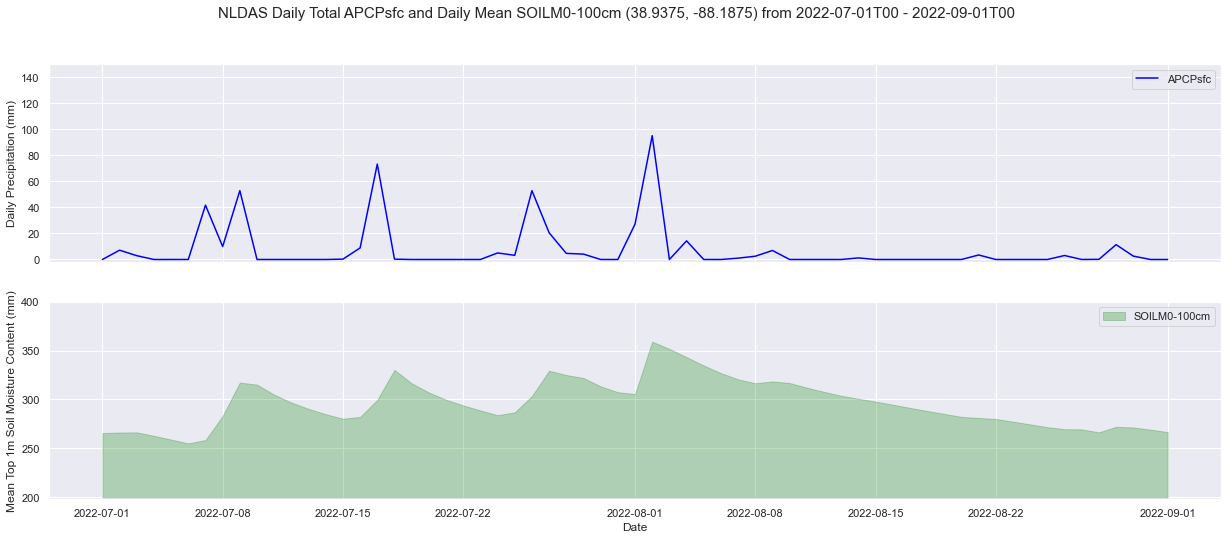

In [16]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(21, 8), sharex=True)
#ax2 = ax1.twinx()

# Convert to mm, aggregate over days and months
daily_precip = df[['time', 'APCPsfc']].groupby(pd.Grouper(key='time', freq='1D')).sum().reset_index()
daily_soil = df[['time', 'SOILM0-100cm']].groupby(pd.Grouper(key='time', freq='1D')).mean().reset_index()

ax1.plot(daily_precip["time"], daily_precip["APCPsfc"], color="blue")
ax1.set_ylim(-2, 150)
ax1.legend(["APCPsfc"])
ax1.set_ylabel("Daily Precipitation (mm)")

ax2.fill_between(daily_soil["time"], 200, daily_soil["SOILM0-100cm"], color="green", alpha=0.25)
ax2.set_ylim(198, 400)
ax2.legend(["SOILM0-100cm"])
ax2.set_ylabel("Mean Top 1m Soil Moisture Content (mm)")
ax2.set_xlabel("Date")

fig.suptitle("NLDAS Daily Total APCPsfc and Daily Mean SOILM0-100cm (38.9375, -88.1875) from 2022-07-01T00 - 2022-09-01T00", size=15)
  
;